# Set up packages and server

In [1]:
# specify the GPU
import os
os.environ['TORCH_HOME'] = 'your/own/cache/directory'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
# Data visualization
import plotly.express as px
from ipywidgets import interact

# Data processing
import pandas as pd
import numpy as np
import geopandas as gpd

# Model training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import copy
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import timm
from sklearn.model_selection import GroupShuffleSplit
# import lightning as L
# from lightning import Trainer
# from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# Others
import os
import sys
import gc
from pathlib import Path
import os.path


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, matthews_corrcoef, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import random


from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm.notebook import tqdm

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src-RCA-UFO')
sys.path.append(PROJECT_SRC_PATH)
import dataset
import visualizations

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3inuvc0o because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
torch.cuda.empty_cache()

In [4]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: NVIDIA A100-PCIE-40GB


# 2. Load and preprocess the training and validation data

In [5]:
def extract_building_id(filepath):
    """
    Extracts the building ID from the given filepath string.
    Knowing that the building ID always contains an underscore and considering the filename
    format '[age_right]_[building_id]_[subscript].jpg', this function returns the 'building_id'.
    """
    # Isolate the filename from the filepath
    filename = filepath.split('/')[-1]
    # Split the filename at underscores
    parts = filename.split('_')
    # Considering the first part is age_right and the last part is the subscript with .jpg,
    # the building ID is everything in between.
    # Rejoin the middle parts to account for underscores within the building ID itself.
    building_id = '_'.join(parts[1:-1])
    return building_id

def get_age_bracket(age):
    if 1900 <= age <= 1924:
        return '1900-1924'
    elif 1925 <= age <= 1945:
        return '1925-1945'
    elif 1946 <= age <= 1959:
        return '1946-1959'
    elif 1960 <= age <= 1969:
        return '1960-1969'
    elif 1970 <= age <= 1984:
        return '1970-1984'
    elif 1985 <= age <= 1999:
        return '1985-1999'
    elif 2000 <= age <= 2050:
        return '2000-2050'
    else:
        return 'Unknown'  # For ages outside the specified brackets or if age couldn't be determined
    
def extract_age_and_name(filepath):
    filename = os.path.basename(filepath)  # Get the filename from the filepath
    age_and_name = filename.split('.')[0]  # Split by dot and take the first part
    age = ''.join(filter(str.isdigit, age_and_name))[:4]  # Extract first 4 digits for age
    if age:  # Ensure age string is not empty
        age = int(age)
        age_bracket = get_age_bracket(age)  # Get the age bracket
    else:  # Default age if no digits found
        age_bracket = 'Unknown'
    return age_bracket


age_bracket_to_int = {
    '1900-1924': 0,
    '1925-1945': 1,
    '1946-1959': 2,
    '1960-1969': 3,
    '1970-1984': 4,
    '1985-1999': 5,
    '2000-2050': 6
}

In [6]:
directories = [
    #Path('/workspace/workspace/ufo-prediction/image_data_NLD'),
    #Path('/workspace/workspace/ufo-prediction/image_data_ESP'),  # Add your second directory path here
    #Path('/workspace/workspace/ufo-prediction/image_data_FRA'),
    Path('/workspace/workspace/ufo-prediction/image_data_NLD_adv'),
    Path('/workspace/workspace/ufo-prediction/image_data_ESP_adv'),  # Add your second directory path here
    Path('/workspace/workspace/ufo-prediction/image_data_FRA_adv')
   # Add your third directory path here
]

filepaths = pd.Series(
    [item for directory in directories for item in directory.glob('**/*.jpg')],
    name='Filepath'
).astype(str)

age_brackets = pd.Series(filepaths.apply(lambda x: extract_age_and_name(x)), name='Age Brackets')
building_ids = pd.Series(filepaths.apply(extract_building_id), name='Building ID')

# Filter to exclude 'Unknown' age brackets and corresponding filepaths and building IDs
filtered_indices = age_brackets != 'Unknown'
filtered_age_brackets = age_brackets[filtered_indices]
filtered_filepaths = filepaths[filtered_indices]
filtered_building_ids = building_ids[filtered_indices]

# Create DataFrame
trainval_df = pd.concat([filtered_filepaths, filtered_age_brackets, filtered_building_ids], axis=1)
trainval_df = trainval_df.sample(frac=1.0, random_state=1).reset_index(drop=True)
trainval_df['Target'] = trainval_df['Age Brackets'].map(age_bracket_to_int)

print(trainval_df.head())

                                            Filepath Age Brackets  \
0  /workspace/workspace/ufo-prediction/image_data...    1925-1945   
1  /workspace/workspace/ufo-prediction/image_data...    2000-2050   
2  /workspace/workspace/ufo-prediction/image_data...    1925-1945   
3  /workspace/workspace/ufo-prediction/image_data...    1900-1924   
4  /workspace/workspace/ufo-prediction/image_data...    2000-2050   

               Building ID  Target  
0    v0.1-NLD.12.3_1-17659       1  
1    v0.1-NLD.10.7_1-37929       6  
2    v0.1-NLD.10.1_1-17019       1  
3  v0.1-FRA.7.1.5.3_1-7951       0  
4    v0.1-NLD.10.22_1-8808       6  


In [7]:
len(trainval_df)

40909

In [8]:
# Initialize the GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=np.random.randint(1, 10000))

# Split the DataFrame into training and validation+test sets
# We use 'Building ID' as the groups to keep images of the same building together
train_idx, valtest_idx = next(gss.split(trainval_df, groups=trainval_df['Building ID']))
train_df = trainval_df.iloc[train_idx]
valtest_df = trainval_df.iloc[valtest_idx]

# Now split the validation+test set into validation and test sets
gss_val_test = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=1)
val_idx, test_idx = next(gss_val_test.split(valtest_df, groups=valtest_df['Building ID']))
val_df = valtest_df.iloc[val_idx]
test_df = valtest_df.iloc[test_idx]

# Check the sizes of each set and sample outputs
print("Training set size:", train_df.shape)
print("Validation set size:", val_df.shape)
print("Testing set size:", test_df.shape)
print("\nSample training data:", train_df.head())
print("\nSample validation data:", val_df.head())
print("\nSample testing data:", test_df.head())


Training set size: (23797, 4)
Validation set size: (12169, 4)
Testing set size: (4943, 4)

Sample training data:                                             Filepath Age Brackets  \
0  /workspace/workspace/ufo-prediction/image_data...    1925-1945   
1  /workspace/workspace/ufo-prediction/image_data...    2000-2050   
3  /workspace/workspace/ufo-prediction/image_data...    1900-1924   
4  /workspace/workspace/ufo-prediction/image_data...    2000-2050   
5  /workspace/workspace/ufo-prediction/image_data...    1946-1959   

               Building ID  Target  
0    v0.1-NLD.12.3_1-17659       1  
1    v0.1-NLD.10.7_1-37929       6  
3  v0.1-FRA.7.1.5.3_1-7951       0  
4    v0.1-NLD.10.22_1-8808       6  
5    v0.1-NLD.12.9_1-17354       2  

Sample validation data:                                              Filepath Age Brackets  \
16  /workspace/workspace/ufo-prediction/image_data...    1900-1924   
19  /workspace/workspace/ufo-prediction/image_data...    1946-1959   
22  /workspace/

In [9]:
def check_building_id_exclusivity(train_df, val_df, test_df):
    # Extract building IDs from each dataset into sets
    train_ids = set(train_df['Building ID'])
    val_ids = set(val_df['Building ID'])
    test_ids = set(test_df['Building ID'])

    # Check for intersections between the sets
    train_val_intersection = train_ids.intersection(val_ids)
    train_test_intersection = train_ids.intersection(test_ids)
    val_test_intersection = val_ids.intersection(test_ids)

    # Report the results
    if not train_val_intersection and not train_test_intersection and not val_test_intersection:
        print("Check passed: No building ID appears in more than one dataset.")
    else:
        if train_val_intersection:
            print("Overlap found between training and validation datasets:", train_val_intersection)
        if train_test_intersection:
            print("Overlap found between training and testing datasets:", train_test_intersection)
        if val_test_intersection:
            print("Overlap found between validation and testing datasets:", val_test_intersection)

# Example usage:
check_building_id_exclusivity(train_df, val_df, test_df)


Check passed: No building ID appears in more than one dataset.


In [10]:
class AgeBracketDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = int(self.dataframe.iloc[idx, -1])  # Assuming the label/target is in the third column

        if self.transform:
            image = self.transform(image)

        return image, label


In [41]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # ResNet-18 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # A common form of augmentation
    #transforms.RandomRotation(15),  # Rotates the image by up to 15 degrees
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly jitters color
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = AgeBracketDataset(train_df, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = AgeBracketDataset(val_df, transform=val_test_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = AgeBracketDataset(test_df, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# 3. Train model

In [17]:
class CustomWeightedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, weight_matrix):
        super(CustomWeightedCrossEntropyLoss, self).__init__()
        self.weight_matrix = weight_matrix

    def forward(self, inputs, targets):
        # Compute probabilities
        probabilities = F.softmax(inputs, dim=1)
        # Get the predicted classes
        _, predictions = torch.max(inputs, 1)
        # Calculate standard cross-entropy loss
        loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Apply weights based on class distances, indexed by true class and predicted class
        weights = self.weight_matrix[targets, predictions]
        weighted_loss = loss * weights

        return weighted_loss.mean()

# Example of creating a weight matrix and using the loss function
num_classes = 7
weight_matrix = torch.ones((num_classes, num_classes))  # example weights, customize as needed
for i in range(num_classes):
    for j in range(num_classes):
        weight_matrix[i, j] = 1 / (1 + abs(i - j))


In [34]:
class CustomWeightedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, weight_matrix):
        super(CustomWeightedCrossEntropyLoss, self).__init__()
        # Ensure the weight matrix is on the correct device upon initialization
        self.weight_matrix = weight_matrix.cuda()  # Move to GPU

    def forward(self, inputs, targets):
        # Get the predicted classes
        _, predictions = torch.max(inputs, 1)
        # Calculate standard cross-entropy loss
        loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Apply weights based on class distances, indexed by true class and predicted class
        weights = self.weight_matrix[targets, predictions]
        weighted_loss = loss * weights

        return weighted_loss.mean()


# Example usage
num_classes = 7
# Create a matrix where element (i, j) is the weight for the distance between classes i and j
weight_matrix = torch.full((num_classes, num_classes), fill_value=1.0)
for i in range(num_classes):
    for j in range(num_classes):
        weight_matrix[i, j] = 1 / (1 + 2*abs(i - j))

In [36]:
weight_matrix

tensor([[1.0000, 0.3333, 0.2000, 0.1429, 0.1111, 0.0909, 0.0769],
        [0.3333, 1.0000, 0.3333, 0.2000, 0.1429, 0.1111, 0.0909],
        [0.2000, 0.3333, 1.0000, 0.3333, 0.2000, 0.1429, 0.1111],
        [0.1429, 0.2000, 0.3333, 1.0000, 0.3333, 0.2000, 0.1429],
        [0.1111, 0.1429, 0.2000, 0.3333, 1.0000, 0.3333, 0.2000],
        [0.0909, 0.1111, 0.1429, 0.2000, 0.3333, 1.0000, 0.3333],
        [0.0769, 0.0909, 0.1111, 0.1429, 0.2000, 0.3333, 1.0000]])

In [37]:
def train_and_evaluate_val_loss(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=50, patience=7, config_details=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_loss = float('inf')  # Initialize the best validation loss as infinity
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    early_stop = False
    history = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        # Use tqdm for the training loop
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_description(f'Training Loss: {running_loss / (progress_bar.n + 1):.4f}')
            progress_bar.update()  # Ensure this call is here to update the progress for each iteration
            
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history.append({'epoch': epoch + 1, 'validation_loss': avg_val_loss, **config_details})

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        scheduler.step(avg_val_loss)  # Learning rate scheduler step based on validation loss

        # Check for improvement based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping check
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            early_stop = True
            break
    
    progress_bar.close()
    
    if not early_stop:
        print('Reached maximum epoch limit.')

    # Load best model weights based on lowest validation loss
    model.load_state_dict(best_model_wts)
    history_df = pd.DataFrame(history)
    return best_val_loss, history_df  # Return the best validation loss achieved

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_data = pd.DataFrame()

# Best Parameters
batch_size = 32
learning_rate = 0.00025
weight_decay = 0.005

# Initialize the model
model = models.resnet18(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to adapt to the number of classes (7 in this case)
num_classes = 7
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Unfreeze the final two layer so it can learn during training
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True


model = model.to(device)
print(model)

# Setup DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Setup optimizer, criterion, and scheduler
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)
criterion = CustomWeightedCrossEntropyLoss(weight_matrix=weight_matrix)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=2, verbose=True)

  # Prepare config details for data recording
config_details = {
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay
    }

# Train the model
best_val_loss, data_df = train_and_evaluate_val_loss(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=25, patience=6, config_details=config_details)
# Append results to the master DataFrame
all_data = pd.concat([all_data, data_df], ignore_index=True)
# Save the complete data to CSV
all_data.to_csv('/workspace/workspace/ufo-prediction/demo/training_scaled.csv', index=False)
print("Best Validation Loss:", best_val_loss)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1/25:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 1/25, Training Loss: 0.5705, Validation Loss: 0.5614


Epoch 2/25:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 2/25, Training Loss: 0.5608, Validation Loss: 0.6172


Epoch 3/25:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 3/25, Training Loss: 0.5599, Validation Loss: 0.5668


Epoch 4/25:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 4/25, Training Loss: 0.5580, Validation Loss: 0.5528


Epoch 5/25:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 5/25, Training Loss: 0.5557, Validation Loss: 0.5474


Epoch 6/25:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 6/25, Training Loss: 0.5457, Validation Loss: 0.5655


Epoch 7/25:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 7/25, Training Loss: 0.5504, Validation Loss: 0.5619


Epoch 8/25:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 8/25, Training Loss: 0.5470, Validation Loss: 0.5592
Epoch     8: reducing learning rate of group 0 to 6.2500e-05.


Epoch 9/25:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 9/25, Training Loss: 0.5436, Validation Loss: 0.5485


Epoch 10/25:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 10/25, Training Loss: 0.5363, Validation Loss: 0.5501


Epoch 11/25:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 11/25, Training Loss: 0.5367, Validation Loss: 0.5491
Epoch    11: reducing learning rate of group 0 to 1.5625e-05.
Early stopping triggered after 11 epochs.
Best Validation Loss: 0.5473774313300926


## 4. Prepare the Test DataLoader

/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


          Metric  Actual Model  Random Model
0       Accuracy        0.2335        0.1475
1      Precision        0.1175        0.1474
2         Recall        0.2335        0.1475
3       F1-Score        0.1376        0.1474
4            MCC        0.1118        0.0033
5  Cohen's Kappa        0.0875        0.0033


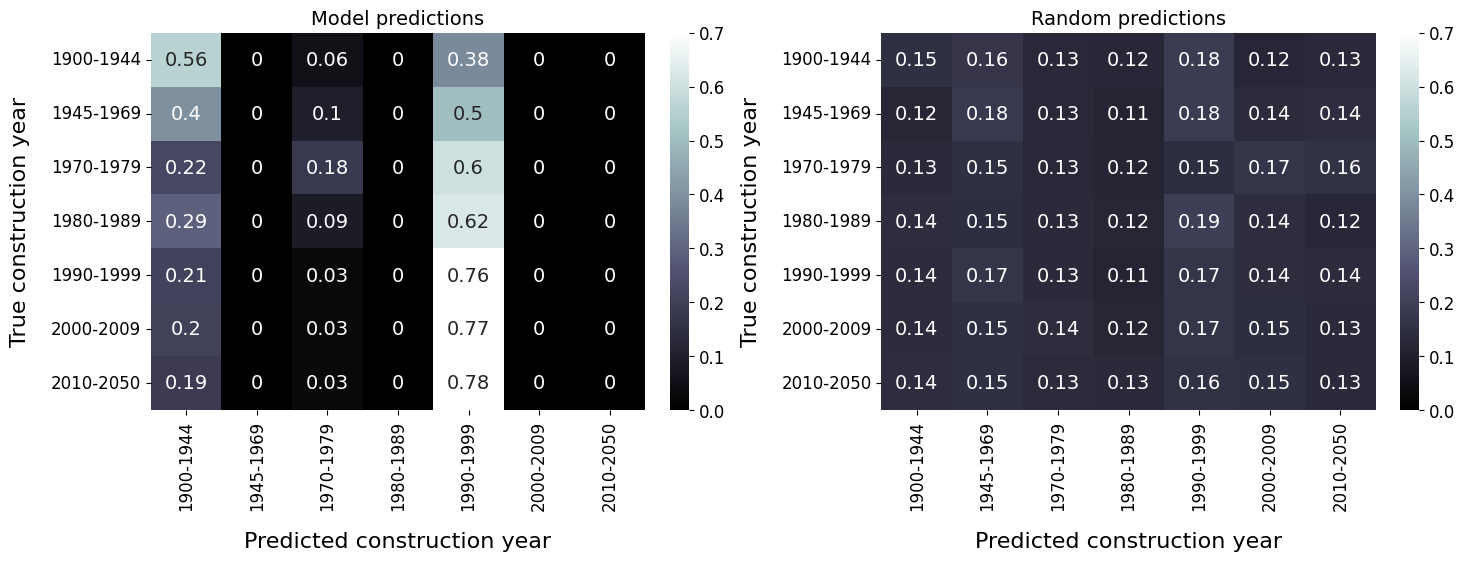

In [42]:
# Evaluate the actual model
model.eval()
true_classes = []
predicted_classes = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_classes.extend(labels.cpu().numpy())
        predicted_classes.extend(predicted.cpu().numpy())

true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

# Generate random predictions
random_predictions = np.random.choice(np.unique(true_classes), size=len(true_classes), p=np.bincount(true_classes)/len(true_classes))

# Compute metrics for the actual model
accuracy = accuracy_score(true_classes, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
mcc = matthews_corrcoef(true_classes, predicted_classes)
cohen_kappa = cohen_kappa_score(true_classes, predicted_classes)

# Compute metrics for the random model
rand_accuracy = accuracy_score(true_classes, random_predictions)
rand_precision, rand_recall, rand_f1, _ = precision_recall_fscore_support(true_classes, random_predictions, average='weighted')
rand_mcc = matthews_corrcoef(true_classes, random_predictions)
rand_cohen_kappa = cohen_kappa_score(true_classes, random_predictions)

# Compute the confusion matrices
# cm = confusion_matrix(true_classes, predicted_classes)
# rand_cm = confusion_matrix(true_classes, random_predictions)

# Create a DataFrame to hold the metrics for easier comparison
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC', 'Cohen\'s Kappa'],
    'Actual Model': [np.round(accuracy, 4), np.round(precision, 4), np.round(recall, 4), np.round(f1, 4), np.round(mcc, 4), np.round(cohen_kappa, 4)],
    'Random Model': [np.round(rand_accuracy, 4), np.round(rand_precision, 4), np.round(rand_recall, 4), np.round(rand_f1, 4), np.round(rand_mcc, 4), np.round(rand_cohen_kappa, 4)]
})

# Display the DataFrame
print(metrics_df)

labels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050']
_, axis = plt.subplots(nrows=1, ncols=2, figsize=(14.55, 5.5), constrained_layout=True)
visualizations.plot_confusion_matrix_manual(true_classes,predicted_classes, class_labels=labels,  vmax=0.7, title="Model predictions", ax=axis[0])
visualizations.plot_confusion_matrix_manual(true_classes,random_predictions, class_labels=labels, vmax=0.7, title="Random predictions", ax=axis[1])
plt.show()


# # Determine the maximum value for normalization of the heatmap colors
# vmax = max(np.max(cm), np.max(rand_cm))

# # Plot the confusion matrices side by side
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# # Confusion Matrix for Actual Model
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], vmin=0, vmax=vmax,
#             xticklabels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050'],
#             yticklabels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050'])
# axes[0].set_title('Confusion Matrix for Actual Model')
# axes[0].set_xlabel('Predicted Age Brackets')
# axes[0].set_ylabel('True Age Brackets')
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
# axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# # Confusion Matrix for Random Model
# sns.heatmap(rand_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], vmin=0, vmax=vmax,
#             xticklabels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050'],
#             yticklabels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050'])
# axes[1].set_title('Confusion Matrix for Random Model')
# axes[1].set_xlabel('Randomly predicted Age Brackets')
# axes[1].set_ylabel('True Age Brackets')
# axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
# axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

# plt.tight_layout()  # Adjust layout to not overlap
# plt.show()


In [43]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming test_df is your DataFrame
test_dataset = CustomDataset(dataframe=test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 5. Infer age brackets

In [44]:
model.eval()  # Set the model to evaluation mode
probabilities_list = []
file_paths = []
predictions = []

with torch.no_grad():
    for inputs, paths in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)  # Apply softmax to convert logits to probabilities
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        probabilities_list.extend(probabilities.cpu().numpy())  # Store probabilities
        file_paths.extend(paths)

# Assuming there are 6 classes, adjust the labels if different
class_labels = [f'Class_{i}' for i in range(probabilities.shape[1])]  # Adjust based on the softmax output size
predictions_df = pd.DataFrame(probabilities_list, columns=class_labels)
predictions_df['Predicted Class'] = predictions
predictions_df['FilePath'] = file_paths  # Add the file paths as a column in the DataFrame
# Extract building IDs and add them as a new column
predictions_df['id'] = predictions_df['FilePath'].apply(extract_building_id)

print(predictions_df.head())  # Display the first few rows of the DataFrame to check the output


    Class_0   Class_1   Class_2   Class_3   Class_4   Class_5   Class_6  \
0  0.026701  0.027833  0.043136  0.080285  0.673010  0.085663  0.063372   
1  0.418111  0.177624  0.159541  0.067298  0.093698  0.041066  0.042662   
2  0.070441  0.058956  0.102940  0.108178  0.482844  0.099052  0.077589   
3  0.544143  0.212645  0.162104  0.032000  0.021347  0.013448  0.014312   
4  0.037844  0.035679  0.054591  0.084135  0.634995  0.084179  0.068577   

   Predicted Class                                           FilePath  \
0                4  /workspace/workspace/ufo-prediction/image_data...   
1                0  /workspace/workspace/ufo-prediction/image_data...   
2                4  /workspace/workspace/ufo-prediction/image_data...   
3                0  /workspace/workspace/ufo-prediction/image_data...   
4                4  /workspace/workspace/ufo-prediction/image_data...   

                      id  
0  v0.1-NLD.10.1_1-17019  
1  v0.1-NLD.12.9_1-21001  
2  v0.1-NLD.10.9_1-32434  
3 

In [104]:
# THIS GIVES YOU ONE OUTPUT LABEL
# model.eval()  # Set model to evaluation mode
# predictions = []
# file_paths = []

# with torch.no_grad():
#     for inputs, paths in test_loader:
#         inputs = inputs.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         predictions.extend(predicted.cpu().numpy())
#         file_paths.extend(paths)


# 6. Concatenate Building ID and use to merge to rca-ufo dataset

In [45]:
unique_ids = predictions_df['id'].unique()
print(len(unique_ids))
print(len(predictions_df))


2165
4943


In [46]:
# Calculate the sum of the probabilities for each class across all images for each building
sum_probs = predictions_df.groupby('id')[['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6']].sum()

# Normalize these sums so that the sum across all classes for each building equals 1
sum_probs_normalized = sum_probs.div(sum_probs.sum(axis=1), axis=0)

# Determine the predicted class for each building based on maximum confidence
# First, find the maximum probability for each class per building
max_conf_probs = predictions_df.groupby('id')[['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6']].max()

# Predicted class is the one with the highest maximum probability
max_conf_probs['Predicted Class'] = max_conf_probs.idxmax(axis=1).str.extract('(\d+)').astype(int)

# Now, get the first file path for each building as a representative path
# This assumes that the 'FilePath' was a column in predictions_df; if not, this line will fail
representative_file_paths = predictions_df.groupby('id')['FilePath'].first()

sum_probs_normalized.reset_index(inplace=True)
max_conf_probs.reset_index(inplace=True)


# Create the final DataFrame to have the normalized sums and the maximum confidence predicted class
final_results = pd.merge(sum_probs_normalized, max_conf_probs[['id', 'Predicted Class']], on='id', how='left')

print(final_results)


                            id   Class_0   Class_1   Class_2   Class_3  \
0      v0.1-ESP.1.1.6.4_1-8544  0.023846  0.030793  0.049038  0.089683   
1      v0.1-ESP.1.1.6.4_1-9874  0.016513  0.019747  0.032275  0.072313   
2      v0.1-ESP.1.1.8.4_1-3869  0.267471  0.127321  0.098373  0.081028   
3      v0.1-ESP.1.1.8.4_1-5378  0.497203  0.177463  0.096918  0.055399   
4     v0.1-ESP.1.2.1.2_1-21057  0.192534  0.097237  0.073290  0.097529   
...                        ...       ...       ...       ...       ...   
2160      v0.1-NLD.9.9_1-17640  0.047128  0.048332  0.072831  0.104158   
2161      v0.1-NLD.9.9_1-18041  0.138702  0.100583  0.089754  0.097104   
2162      v0.1-NLD.9.9_1-20127  0.310037  0.183251  0.187462  0.087321   
2163      v0.1-NLD.9.9_1-22453  0.386225  0.193648  0.164031  0.068688   
2164       v0.1-NLD.9.9_1-9968  0.051369  0.052223  0.080034  0.108023   

       Class_4   Class_5   Class_6  Predicted Class  
0     0.591617  0.125280  0.089744                4  
1  

In [109]:
## OLD METHOD USING MODE AND MEAN

# import numpy as np

# # Assuming predictions_df is already defined and has 'id' and 'CNN_age_bracket' columns

# # Step 1 & 2: Group by 'id' and 'CNN_age_bracket' and count occurrences
# age_bracket_counts = predictions_df.groupby(['id', 'CNN_age_bracket']).size().reset_index(name='counts')

# # Determine the most frequent age bracket for each 'id'
# def most_frequent_age_bracket(sub_df):
#     max_count = sub_df['counts'].max()
#     most_frequent = sub_df[sub_df['counts'] == max_count]
#     if len(most_frequent) == 1:
#         # If there's a single most frequent value, return it
#         return most_frequent['CNN_age_bracket'].values[0]
#     else:
#         # If there's a tie, calculate the average and round to the nearest whole number
#         avg = most_frequent['CNN_age_bracket'].astype(float).mean()
#         return round(avg)

# # Apply the function to each 'id' group
# unique_predictions = age_bracket_counts.groupby('id').apply(most_frequent_age_bracket).reset_index()
# unique_predictions.columns = ['id', 'CNN_age_bracket']

# # Now, unique_predictions contains unique ids with the selected CNN_age_bracket
# print(len(unique_predictions['id'].unique()), len(unique_predictions))


1768 1768


In [47]:
# List of countries to loop through
countries = ['NLD', 'ESP', 'FRA']
base_path = '/workspace/workspace/ufo-prediction/demo'
all_data = []  # To store data from all countries

for country in countries:
    # Construct the path to the pickle file
    path_data = os.path.join(base_path, f'df-{country}.pkl')
    # Read the country-specific DataFrame
    df_country = pd.read_pickle(path_data)
    print(f' Read data for {country}')
    # Merge with predictions DataFrame
    merged_df = pd.merge(final_results, df_country, on='id', how='left', indicator=True)
    print(f' Merged data for {country}')
    # Append to the list for concatenation later
    all_data.append(merged_df)

# Concatenate all merged DataFrames
all_df = pd.concat(all_data, ignore_index=True)

 Read data for NLD
 Merged data for NLD
 Read data for ESP
 Merged data for ESP
 Read data for FRA
 Merged data for FRA


In [48]:
all_df

,id,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Predicted Class,source_file,...,street_betweeness_global_max_within_buffer_100,TouchesIndexes,street_based_block_av_phi_inter_buffer_500,total_length_street_city,total_buildings_footprint_city,Phi,street_based_block_std_area_inter_buffer_100,type,neighborhood,_merge
0,v0.1-ESP.1.1.6.4_1-8544,0.023846,0.030793,0.049038,0.089683,0.591617,0.125280,0.089744,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,v0.1-ESP.1.1.6.4_1-9874,0.016513,0.019747,0.032275,0.072313,0.705050,0.089161,0.064941,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,v0.1-ESP.1.1.8.4_1-3869,0.267471,0.127321,0.098373,0.081028,0.301322,0.070571,0.053914,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,v0.1-ESP.1.1.8.4_1-5378,0.497203,0.177463,0.096918,0.055399,0.103380,0.034582,0.035055,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,v0.1-ESP.1.2.1.2_1-21057,0.192534,0.097237,0.073290,0.097529,0.394197,0.079999,0.065214,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6490,v0.1-NLD.9.9_1-17640,0.047128,0.048332,0.072831,0.104158,0.518220,0.124946,0.084385,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6491,v0.1-NLD.9.9_1-18041,0.138702,0.100583,0.089754,0.097104,0.420898,0.087726,0.065233,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6492,v0.1-NLD.9.9_1-20127,0.310037,0.183251,0.187462,0.087321,0.123471,0.059281,0.049177,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6493,v0.1-NLD.9.9_1-22453,0.386225,0.193648,0.164031,0.068688,0.106778,0.040243,0.040387,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [49]:
# Select columns to consider for NA (all but 'CNN_age_bracket')
cols_to_check = all_df.columns.difference(['Predicted Class', 'id', 'Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', '_merge'])

# Drop rows where all the selected columns are NA
cleaned_df = all_df.dropna(subset=cols_to_check, how='all')

# Now, cleaned_df should have rows dropped where every column except 'CNN_age_bracket' was NA
print(len(cleaned_df))


2165


In [50]:
# Counting how many rows fall into each merge category
merge_counts = cleaned_df['_merge'].value_counts()

print(merge_counts)

_merge
both          2165
left_only        0
right_only       0
Name: count, dtype: int64


In [51]:
cleaned_df

,id,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Predicted Class,source_file,...,street_betweeness_global_max_within_buffer_100,TouchesIndexes,street_based_block_av_phi_inter_buffer_500,total_length_street_city,total_buildings_footprint_city,Phi,street_based_block_std_area_inter_buffer_100,type,neighborhood,_merge
1004,v0.1-NLD.1.11_1-19088,0.023194,0.029928,0.049785,0.088234,0.602589,0.120446,0.085823,4,NL_lod12_2d_pand_2,...,0.056066,[19088],0.337143,8.887122e+05,2.887787e+06,0.551174,5.975969e+05,NaN,547d1be9,both
1005,v0.1-NLD.1.1_1-13644,0.121078,0.142983,0.436511,0.107897,0.099262,0.051499,0.040770,2,NL_lod12_2d_pand_2,...,0.037504,[13644],0.396432,1.013007e+06,2.966798e+06,0.598186,5.294541e+05,NaN,a50451ac,both
1006,v0.1-NLD.1.2_1-21267,0.023132,0.024886,0.046028,0.073222,0.683996,0.086742,0.061994,4,NL_lod12_2d_pand_2,...,0.019270,[21267],0.378814,7.084962e+05,3.936964e+06,0.504573,4.913307e+05,NaN,4108f866,both
1007,v0.1-NLD.1.2_1-6956,0.028526,0.032950,0.053943,0.093981,0.583175,0.123832,0.083593,4,NL_lod12_2d_pand_2,...,0.020112,[6956],0.325508,7.084962e+05,3.936964e+06,0.618989,4.843252e+05,NaN,cb92baa3,both
1008,v0.1-NLD.1.3_1-11744,0.084167,0.063443,0.079570,0.109220,0.472091,0.112994,0.078515,4,NL_lod12_2d_pand_2,...,0.062462,[11744],0.225806,9.779260e+05,3.148352e+06,0.516409,6.590574e+06,NaN,f93411d6,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5329,v0.1-FRA.9.4.3.8_1-3382,0.410667,0.158796,0.081921,0.069955,0.176811,0.052577,0.049273,0,BATIMENT-normandie,...,0.087577,"[3381, 8032, 8033, 3382]",0.286737,6.584433e+05,1.485116e+06,0.517742,2.536565e+05,residential,efceeee8,both
5330,v0.1-FRA.9.5.1.17_1-2783,0.020952,0.027567,0.045523,0.086992,0.611474,0.121566,0.085926,4,BATIMENT-normandie,...,0.032128,[2783],0.288695,7.053070e+05,2.097088e+06,0.510567,8.486095e+05,non-residential,08af5f7a,both
5331,v0.1-FRA.9.5.1.18_1-2888,0.044113,0.045838,0.060616,0.104406,0.516057,0.135387,0.093582,4,BATIMENT-normandie,...,0.057448,[2888],0.217120,5.843162e+05,1.076556e+06,0.598157,2.318356e+06,non-residential,a667c6dc,both
5332,v0.1-FRA.9.5.3.1_1-4383,0.029534,0.032854,0.051249,0.092952,0.599008,0.114775,0.079628,4,BATIMENT-normandie,...,0.016444,"[901, 5838, 13990, 1492, 7772, 1426, 9716, 583...",0.290407,5.117132e+05,1.427673e+06,0.580948,1.577956e+05,residential,8bbe4115,both


In [52]:
# Save the concatenated DataFrame to CSV
output_path = os.path.join('/workspace/workspace/ufo-prediction/demo/ufo-CNN_ALL_weighted_loss2.csv')
cleaned_df.to_csv(output_path, index=False)

In [53]:
gc.collect()

0